In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [40]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [41]:
def generator(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [42]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [43]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [44]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [21]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [22]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [24]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [26]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, dloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                #if np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0:
                if len(dones) > 1:
                    # print('np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0: ', 
                    #       np.count_nonzero(dones), len(dones), np.max(rates))
                    break
            #             if np.count_nonzero(dones)!=1 and len(dones) < 1 and np.max(rates) <= 0:
            #                 print(np.count_nonzero(dones), len(dones), np.max(rates))
            #                 break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.next_states: next_states,
                                            #model.rewards: rewards,
                                            model.dones: dones,
                                            model.rates: rates})
            dloss, _ = sess.run([model.d_loss, model.d_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print('dones:', 
            #       len(dones), np.count_nonzero(dones), 
            #       len(dones1), np.count_nonzero(dones1), 
            #       len(dones2), np.count_nonzero(dones2))
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:1.4083 dloss:2.2917 aloss2:1.2625 exploreP:0.9983
Episode:1 meanR:25.0000 R:33.0000 rate:0.0660 aloss:1.4052 dloss:2.2806 aloss2:1.2688 exploreP:0.9951
Episode:2 meanR:20.6667 R:12.0000 rate:0.0240 aloss:1.4117 dloss:2.2294 aloss2:1.3135 exploreP:0.9939
Episode:3 meanR:23.2500 R:31.0000 rate:0.0620 aloss:1.4017 dloss:2.2158 aloss2:1.3192 exploreP:0.9908
Episode:4 meanR:25.0000 R:32.0000 rate:0.0640 aloss:1.3991 dloss:2.2061 aloss2:1.3176 exploreP:0.9877
Episode:5 meanR:23.6667 R:17.0000 rate:0.0340 aloss:1.3958 dloss:2.2056 aloss2:1.3119 exploreP:0.9860
Episode:6 meanR:22.4286 R:15.0000 rate:0.0300 aloss:1.3883 dloss:2.1737 aloss2:1.3431 exploreP:0.9846
Episode:7 meanR:22.0000 R:19.0000 rate:0.0380 aloss:1.3925 dloss:2.1642 aloss2:1.3507 exploreP:0.9827
Episode:8 meanR:22.7778 R:29.0000 rate:0.0580 aloss:1.3945 dloss:2.1422 aloss2:1.3631 exploreP:0.9799
Episode:9 meanR:23.8000 R:33.0000 rate:0.0660 aloss:1.3927 dloss:2.1224 aloss2:1.3

Episode:80 meanR:25.4938 R:21.0000 rate:0.0420 aloss:1.3886 dloss:0.9434 aloss2:2.9911 exploreP:0.8153
Episode:81 meanR:25.7439 R:46.0000 rate:0.0920 aloss:1.3786 dloss:0.9580 aloss2:2.9784 exploreP:0.8116
Episode:82 meanR:25.6747 R:20.0000 rate:0.0400 aloss:1.3720 dloss:0.9619 aloss2:3.0005 exploreP:0.8100
Episode:83 meanR:26.0238 R:55.0000 rate:0.1100 aloss:1.3810 dloss:0.9103 aloss2:3.0951 exploreP:0.8056
Episode:84 meanR:25.8824 R:14.0000 rate:0.0280 aloss:1.3785 dloss:0.9194 aloss2:3.0548 exploreP:0.8045
Episode:85 meanR:26.0000 R:36.0000 rate:0.0720 aloss:1.3803 dloss:0.8677 aloss2:3.2195 exploreP:0.8016
Episode:86 meanR:25.9195 R:19.0000 rate:0.0380 aloss:1.3744 dloss:0.8718 aloss2:3.2383 exploreP:0.8001
Episode:87 meanR:26.5000 R:77.0000 rate:0.1540 aloss:1.3777 dloss:0.8629 aloss2:3.2783 exploreP:0.7941
Episode:88 meanR:26.7079 R:45.0000 rate:0.0900 aloss:1.3771 dloss:0.8147 aloss2:3.4754 exploreP:0.7906
Episode:89 meanR:26.6000 R:17.0000 rate:0.0340 aloss:1.3801 dloss:0.8227 

Episode:159 meanR:34.8600 R:42.0000 rate:0.0840 aloss:1.3772 dloss:0.6208 aloss2:6.0125 exploreP:0.6084
Episode:160 meanR:36.0500 R:129.0000 rate:0.2580 aloss:1.3773 dloss:0.5568 aloss2:6.0563 exploreP:0.6008
Episode:161 meanR:36.5600 R:76.0000 rate:0.1520 aloss:1.3676 dloss:0.5521 aloss2:6.1078 exploreP:0.5963
Episode:162 meanR:37.3800 R:104.0000 rate:0.2080 aloss:1.3686 dloss:0.5768 aloss2:6.1502 exploreP:0.5902
Episode:163 meanR:37.6100 R:34.0000 rate:0.0680 aloss:1.3808 dloss:0.5679 aloss2:6.1023 exploreP:0.5882
Episode:164 meanR:38.6100 R:124.0000 rate:0.2480 aloss:1.3733 dloss:0.5681 aloss2:6.0558 exploreP:0.5811
Episode:165 meanR:39.4400 R:98.0000 rate:0.1960 aloss:1.3704 dloss:0.5647 aloss2:6.0824 exploreP:0.5756
Episode:166 meanR:42.6200 R:363.0000 rate:0.7260 aloss:1.3700 dloss:0.5619 aloss2:6.0980 exploreP:0.5554
Episode:167 meanR:44.0500 R:161.0000 rate:0.3220 aloss:1.3730 dloss:0.5837 aloss2:6.1575 exploreP:0.5467
Episode:168 meanR:45.1400 R:145.0000 rate:0.2900 aloss:1.37

Episode:237 meanR:214.9600 R:123.0000 rate:0.2460 aloss:1.3792 dloss:0.9039 aloss2:4.6906 exploreP:0.0864
Episode:238 meanR:218.3800 R:378.0000 rate:0.7560 aloss:1.3730 dloss:0.9477 aloss2:4.6913 exploreP:0.0835
Episode:239 meanR:218.4800 R:33.0000 rate:0.0660 aloss:1.4228 dloss:1.1829 aloss2:4.6416 exploreP:0.0833
Episode:240 meanR:218.8800 R:94.0000 rate:0.1880 aloss:1.3992 dloss:0.9274 aloss2:4.6484 exploreP:0.0826
Episode:241 meanR:223.7600 R:500.0000 rate:1.0000 aloss:1.3645 dloss:0.9077 aloss2:4.7580 exploreP:0.0791
Episode:242 meanR:228.5900 R:500.0000 rate:1.0000 aloss:1.3935 dloss:0.9930 aloss2:4.6515 exploreP:0.0757
Episode:243 meanR:233.3600 R:500.0000 rate:1.0000 aloss:1.3735 dloss:0.9984 aloss2:4.5949 exploreP:0.0725
Episode:244 meanR:237.8300 R:500.0000 rate:1.0000 aloss:1.3876 dloss:1.0112 aloss2:4.5501 exploreP:0.0694
Episode:245 meanR:242.5100 R:500.0000 rate:1.0000 aloss:1.3818 dloss:1.0230 aloss2:4.5591 exploreP:0.0665
Episode:246 meanR:246.8200 R:500.0000 rate:1.000

Episode:315 meanR:444.4600 R:322.0000 rate:0.6440 aloss:1.3222 dloss:1.4717 aloss2:3.3034 exploreP:0.0119
Episode:316 meanR:444.0600 R:135.0000 rate:0.2700 aloss:1.3213 dloss:1.4974 aloss2:3.3000 exploreP:0.0119
Episode:317 meanR:444.0600 R:500.0000 rate:1.0000 aloss:1.3215 dloss:1.4979 aloss2:3.2824 exploreP:0.0118
Episode:318 meanR:444.4800 R:227.0000 rate:0.4540 aloss:1.3313 dloss:1.4659 aloss2:3.3032 exploreP:0.0118
Episode:319 meanR:440.2100 R:73.0000 rate:0.1460 aloss:1.3360 dloss:1.4848 aloss2:3.3400 exploreP:0.0118
Episode:320 meanR:437.9100 R:270.0000 rate:0.5400 aloss:1.2832 dloss:1.5786 aloss2:3.2167 exploreP:0.0117
Episode:321 meanR:437.6200 R:114.0000 rate:0.2280 aloss:1.3010 dloss:1.5348 aloss2:3.2011 exploreP:0.0117
Episode:322 meanR:433.8900 R:127.0000 rate:0.2540 aloss:1.3035 dloss:1.5471 aloss2:3.1701 exploreP:0.0117
Episode:323 meanR:436.6100 R:500.0000 rate:1.0000 aloss:1.3229 dloss:1.4826 aloss2:3.2368 exploreP:0.0116
Episode:324 meanR:434.3900 R:77.0000 rate:0.154

Episode:393 meanR:399.2700 R:500.0000 rate:1.0000 aloss:1.1813 dloss:1.7134 aloss2:2.6676 exploreP:0.0101
Episode:394 meanR:399.2700 R:500.0000 rate:1.0000 aloss:1.1784 dloss:1.7258 aloss2:2.6739 exploreP:0.0101
Episode:395 meanR:397.6500 R:338.0000 rate:0.6760 aloss:1.1701 dloss:1.7308 aloss2:2.6615 exploreP:0.0101
Episode:396 meanR:400.1000 R:500.0000 rate:1.0000 aloss:1.1757 dloss:1.7295 aloss2:2.6511 exploreP:0.0101
Episode:397 meanR:400.1000 R:500.0000 rate:1.0000 aloss:1.1756 dloss:1.7514 aloss2:2.5982 exploreP:0.0101
Episode:398 meanR:400.1000 R:500.0000 rate:1.0000 aloss:1.1621 dloss:1.7721 aloss2:2.5683 exploreP:0.0101
Episode:399 meanR:400.1000 R:500.0000 rate:1.0000 aloss:1.1714 dloss:1.7600 aloss2:2.5540 exploreP:0.0101
Episode:400 meanR:400.1000 R:500.0000 rate:1.0000 aloss:1.1649 dloss:1.7597 aloss2:2.5712 exploreP:0.0101
Episode:401 meanR:400.1000 R:500.0000 rate:1.0000 aloss:1.1696 dloss:1.7536 aloss2:2.5467 exploreP:0.0101
Episode:402 meanR:401.4700 R:500.0000 rate:1.0

Episode:471 meanR:493.3100 R:500.0000 rate:1.0000 aloss:1.1217 dloss:1.4720 aloss2:2.8192 exploreP:0.0100
Episode:472 meanR:494.2500 R:500.0000 rate:1.0000 aloss:1.1214 dloss:1.4660 aloss2:2.8328 exploreP:0.0100
Episode:473 meanR:494.2500 R:500.0000 rate:1.0000 aloss:1.1190 dloss:1.4453 aloss2:2.8654 exploreP:0.0100
Episode:474 meanR:494.2500 R:500.0000 rate:1.0000 aloss:1.1191 dloss:1.4514 aloss2:2.8852 exploreP:0.0100
Episode:475 meanR:494.2500 R:500.0000 rate:1.0000 aloss:1.1211 dloss:1.4376 aloss2:2.9065 exploreP:0.0100
Episode:476 meanR:495.8700 R:500.0000 rate:1.0000 aloss:1.1191 dloss:1.4297 aloss2:2.9361 exploreP:0.0100
Episode:477 meanR:495.8700 R:500.0000 rate:1.0000 aloss:1.1221 dloss:1.4289 aloss2:2.9440 exploreP:0.0100
Episode:478 meanR:495.8700 R:500.0000 rate:1.0000 aloss:1.1239 dloss:1.4347 aloss2:2.9438 exploreP:0.0100
Episode:479 meanR:495.8700 R:500.0000 rate:1.0000 aloss:1.1222 dloss:1.4166 aloss2:2.9799 exploreP:0.0100
Episode:480 meanR:497.0900 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

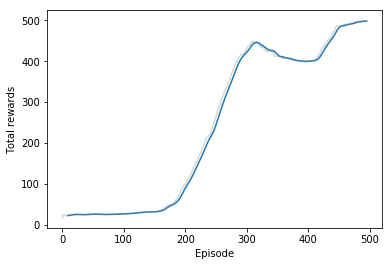

In [30]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

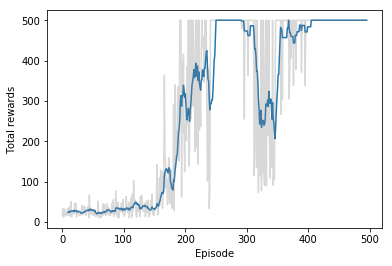

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'A losses')

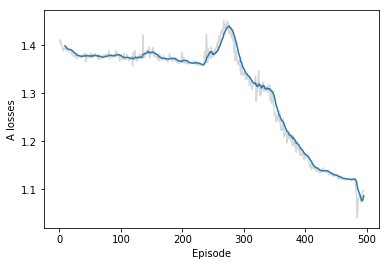

In [36]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('A losses')

Text(0, 0.5, 'D losses')

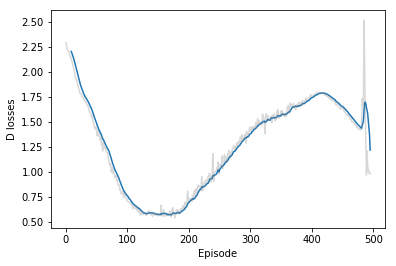

In [37]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0, 0.5, 'A losses 2')

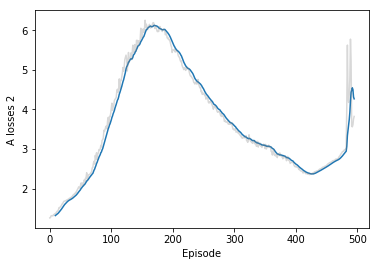

In [38]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('A losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [39]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
